# Импорт необходимых библиотек

In [8]:
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Настройка среды

In [9]:
class TicTacToe:
    def __init__(self, size=3):
        self.size = size
        # Создаем пустое игровое поле заданного размера
        self.board = np.zeros((self.size, self.size), dtype=int)
        # Устанавливаем текущего игрока (1 - первый игрок, 2 - второй игрок)
        self.current_player = 1

    def reset(self):
        # Сбрасываем игровое поле и устанавливаем текущего игрока на первого
        self.board = np.zeros((self.size, self.size), dtype=int)
        self.current_player = 1

    def available_actions(self):
        # Возвращаем список доступных ходов (пустых клеток на игровом поле)
        return [(i, j) for i in range(self.size) for j in range(self.size) if self.board[i, j] == 0]

    def make_move(self, row, col):
        # Проверяем, что клетка пуста
        if self.board[row, col] == 0:
            # Выполняем ход текущего игрока
            self.board[row, col] = self.current_player
            # Проверяем, не выиграл ли текущий игрок
            if self.check_winner(self.current_player):
                return self.current_player
            # Проверяем, не завершилась ли игра ничьей
            elif len(self.available_actions()) == 0:
                return 0
            else:
                # Меняем текущего игрока
                self.current_player = 3 - self.current_player
                return None
        else:
            # Если клетка занята, вызываем ошибку
            raise ValueError("Эта клетка уже занята!")

    def check_winner(self, player):
        # Проверяем строки и столбцы на наличие победы
        for i in range(self.size):
            if np.all(self.board[i, :] == player) or np.all(self.board[:, i] == player):
                return True
        # Проверяем главную и побочную диагонали на наличие победы
        if np.all(np.diag(self.board) == player) or np.all(np.diag(np.fliplr(self.board)) == player):
            return True
        # Если победы нет, возвращаем False
        return False


# Настройка агента

In [ ]:
class QLearningAgent:
    def __init__(self, alpha=0.1, gamma=0.99, epsilon=0.1, epsilon_decay=0.995, epsilon_min=0.1):
        # Инициализация параметров Q-learning агента
        self.q_table = {}  # Q-таблица для хранения значений Q
        self.alpha = alpha  # Скорость обучения (learning rate)
        self.gamma = gamma  # Коэффициент дисконтирования (discount factor)
        self.epsilon = epsilon  # Начальная вероятность выбора случайного действия (exploration rate)
        self.epsilon_decay = epsilon_decay  # Коэффициент уменьшения epsilon после каждой итерации
        self.epsilon_min = epsilon_min  # Минимальное значение epsilon

    def get_state_key(self, board):
        # Преобразование игрового поля в ключ состояния для использования в Q-таблице
        return tuple(board.flatten())  # Преобразуем матрицу в плоский массив, затем в кортеж

    def choose_action(self, state, available_actions):
        # Выбор действия на основе epsilon-greedy стратегии
        if not available_actions:
            return None  # Если нет доступных действий, возвращаем None

        if random.uniform(0, 1) < self.epsilon:
            # Случайный выбор действия (exploration)
            return random.choice(available_actions)
        else:
            # Выбор действия с максимальным Q-значением (exploitation)
            q_values = [self.q_table.get((state, action), 0) for action in available_actions]  # Получаем Q-значения для всех доступных действий
            max_q = max(q_values)  # Находим максимальное Q-значение
            max_actions = [action for action, q in zip(available_actions, q_values) if q == max_q]  # Находим действия с максимальным Q-значением
            return random.choice(max_actions)  # Возвращаем одно из действий с максимальным Q-значением

    def update_q_table(self, state, action, reward, next_state, done, available_actions_next):
        # Обновление Q-таблицы на основе полученного опыта
        state_key = self.get_state_key(state)  # Получаем ключ текущего состояния
        next_state_key = self.get_state_key(next_state)  # Получаем ключ следующего состояния
        current_q = self.q_table.get((state_key, action), 0)  # Текущее Q-значение для данной пары (состояние, действие)

        if done:
            target = reward  # Если игра завершена, целевое значение равно награде
        else:
            next_q_values = [self.q_table.get((next_state_key, a), 0) for a in available_actions_next]  # Q-значения для всех доступных действий в следующем состоянии
            target = reward + self.gamma * max(next_q_values, default=0)  # Целевое значение с учетом будущих наград

        self.q_table[(state_key, action)] = current_q + self.alpha * (target - current_q)  # Обновление Q-значения с использованием формулы Q-learning

    def save_q_table(self, filename='q_table.pkl'):
        # Сохранение Q-таблицы в файл
        with open(filename, 'wb') as f:  # Открываем файл для записи в двоичном режиме
            pickle.dump(self.q_table, f)  # Сохраняем Q-таблицу в файл с помощью pickle

    def load_q_table(self, filename='q_table.pkl'):
        # Загрузка Q-таблицы из файла
        with open(filename, 'rb') as f:  # Открываем файл для чтения в двоичном режиме
            self.q_table = pickle.load(f)  # Загружаем Q-таблицу из файла с помощью pickle


# Функции для взаимодействия с пользователем

In [ ]:
def display_board(game):
    """Выводит текущее состояние поля."""
    clear_output()  # Очищаем вывод
    for i in range(game.size):  # Проходим по всем строкам игрового поля
        row = ' | '.join(['X' if x == 1 else 'O' if x == 2 else ' ' for x in game.board[i]])  # Формируем строку для текущей строки поля
        print(row)  # Выводим строку
        if i < game.size - 1:
            print('-' * (game.size * 4 - 3))  # Выводим разделительную линию между строками

def play_game_with_console_and_agent(size, agent):
    """Запускает игру с участием пользователя и агента."""
    game = TicTacToe(size)  # Создаем экземпляр игры
    game.reset()  # Сбрасываем игру

    print("Добро пожаловать в игру Крестики-Нолики!")  # Приветственное сообщение
    display_board(game)  # Выводим игровое поле

    while True:
        # Ход игрока 1 (человек)
        print(f"Ход игрока 1 (X)")  # Сообщение о ходе первого игрока
        try:
            row = int(input(f"Введите номер строки (1-{size}): ")) - 1  # Запрашиваем номер строки
            col = int(input(f"Введите номер столбца (1-{size}): ")) - 1  # Запрашиваем номер столбца
            result = game.make_move(row, col)  # Выполняем ход игрока
            display_board(game)  # Выводим игровое поле
            if result is not None:  # Проверяем результат игры
                if result == 1:
                    print("Поздравляем! Игрок 1 (X) победил!")  # Сообщение о победе первого игрока
                elif result == 0:
                    print("Ничья!")  # Сообщение о ничье
                break  # Завершаем игру
        except ValueError:
            print("Недопустимый ход. Попробуйте снова.")  # Сообщение о недопустимом ходе

        # Ход агента (игрок 2)
        print(f"Ход игрока 2 (O) - Агент")  # Сообщение о ходе агента
        available_actions = game.available_actions()  # Получаем доступные действия
        state = game.board.copy()  # Копируем текущее состояние игрового поля
        action = agent.choose_action(agent.get_state_key(state), available_actions)  # Агенты выбирают действие

        if action:
            row, col = action  # Применяем выбранное действие
            result = game.make_move(row, col)  # Выполняем ход агента
            display_board(game)  # Выводим игровое поле
            if result is not None:  # Проверяем результат игры
                if result == 2:
                    print("Агент (игрок 2) победил!")  # Сообщение о победе агента
                elif result == 0:
                    print("Ничья!")  # Сообщение о ничье
                break  # Завершаем игру
        else:
            print("Нет доступных ходов!")  # Сообщение об отсутствии доступных ходов
            break  # Завершаем игру

# Функция тренировки агента и построение сглаженной кривой обучения

In [11]:
def train_agent(size=3, episodes=20000):
    agent = QLearningAgent()  # Создание экземпляра агента на основе Q-обучения
    game = TicTacToe(size=size)  # Создание экземпляра игры с указанным размером поля
    win_history = []  # Инициализация списка для хранения истории побед

    for episode in range(1, episodes + 1):
        game.reset()  # Сброс игрового поля в начальное состояние
        state = game.board.copy()  # Копирование текущего состояния игрового поля
        done = False  # Флаг завершения игры
        current_player = 1  # Текущий игрок (1 - первый игрок)

        while not done:
            available_actions = game.available_actions()  # Получение списка доступных действий
            action = agent.choose_action(agent.get_state_key(state), available_actions)  # Выбор действия агентом

            if action is None:
                break  # Если нет доступных действий, выход из цикла

            result = game.make_move(*action)  # Выполнение хода на игровом поле
            next_state = game.board.copy()  # Копирование следующего состояния игрового поля

            if result == current_player:
                reward = 10  # Награда за победу
                done = True  # Игра завершена
            elif result == 0:
                reward = 5  # Награда за ничью
                done = True  # Игра завершена
            else:
                reward = -0.5  # Штраф за продолжающуюся игру
                done = False  # Игра продолжается

            available_actions_next = game.available_actions()  # Получение списка доступных действий для следующего состояния
            agent.update_q_table(state, action, reward, next_state, done, available_actions_next)  # Обновление Q-таблицы

            state = next_state.copy()  # Переход к следующему состоянию

        if result == 1:
            win_history.append(1)  # Запись победы первого игрока
        elif result == 0:
            win_history.append(0.5)  # Запись ничьи
        else:
            win_history.append(0)  # Запись поражения

        if agent.epsilon > agent.epsilon_min:
            agent.epsilon *= agent.epsilon_decay  # Уменьшение epsilon для уменьшения вероятности случайных действий

        if episode % 1000 == 0:
            print(f'Episode {episode}/{episodes} completed.')  # Вывод информации о завершении очередного блока эпизодов

    agent.save_q_table()  # Сохранение Q-таблицы на диск
    return agent, win_history  # Возврат обученного агента и истории побед


# Построение кривой обучения

In [12]:
def plot_learning_curve(win_history, window_size=100):
    # Вычисляем скользящее среднее выигрышей для сглаживания кривой обучения
    smoothed_win_history = np.convolve(win_history, np.ones(window_size) / window_size, mode='valid')
    
    # Создаем график скользящего среднего выигрышей
    plt.plot(smoothed_win_history, label="Скользящее среднее выигрышей")
    
    # Устанавливаем метки для осей x и y
    plt.xlabel('Эпизоды')
    plt.ylabel('Средний результат (1 - победа, 0.5 - ничья, 0 - поражение)')
    
    # Устанавливаем заголовок графика
    plt.title('Кривая обучения модели')
    
    # Добавляем легенду на график
    plt.legend()
    
    # Отображаем график
    plt.show()


# Инициализация агента и обучение

Q-таблица не найдена. Начинаем обучение агента...
Episode 1000/20000 completed.
Episode 2000/20000 completed.
Episode 3000/20000 completed.
Episode 4000/20000 completed.
Episode 5000/20000 completed.
Episode 6000/20000 completed.
Episode 7000/20000 completed.
Episode 8000/20000 completed.
Episode 9000/20000 completed.
Episode 10000/20000 completed.
Episode 11000/20000 completed.
Episode 12000/20000 completed.
Episode 13000/20000 completed.
Episode 14000/20000 completed.
Episode 15000/20000 completed.
Episode 16000/20000 completed.
Episode 17000/20000 completed.
Episode 18000/20000 completed.
Episode 19000/20000 completed.
Episode 20000/20000 completed.
Отображение графика обучения


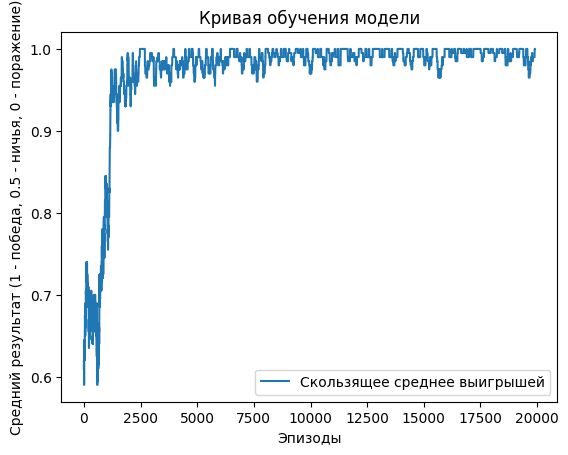

In [13]:
# Запрос размера поля у пользователя
size = int(input("Введите размер поля (например, 3 для 3x3): "))

# Создание экземпляра агента Q-learning
agent = QLearningAgent()
try:
    # Попытка загрузить Q-таблицу из файла
    agent.load_q_table('q_table.pkl')
    print("Q-таблица загружена.")
    win_history = None  # История выигрышей отсутствует, т.к. агент уже обучен
except FileNotFoundError:
    # Если файл не найден, начинаем обучение агента
    print("Q-таблица не найдена. Начинаем обучение агента...")
    agent, win_history = train_agent(size=size)  # Обучение агента и получение истории выигрышей

    if win_history is not None:
        # Если история выигрышей существует, отображаем график обучения
        print("Отображение графика обучения")
        plot_learning_curve(win_history)  # Построение и отображение кривой обучения

# Запуск игры

In [ ]:
# Вывод сообщения о запуске игры
print("Запуск игры...")

# Запуск игры с участием пользователя и агента
play_game_with_console_and_agent(size, agent)


X |   | O
---------
  | X |  
---------
  | O | X
Поздравляем! Игрок 1 (X) победил!
